### Dataset link 
#### https://universe.roboflow.com/research-zwl99/railwayvision3/dataset/3

#### install the dependencies 
* here i use folowing versions 

  * detectron2 = $0.1.3$ 
  * python = $3.10.12$
  * torch =  $2.3.0+cu121$
  * torchvision = $0.18.0+cu121$
  * numpy = $1.26.3
  * opencv-python = $4.10.0.84$


In [ ]:

# !pip install cython pyyaml==5.1
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# import torch, torchvision
# print(torch.__version__, torch.cuda.is_available())
# !gcc --version

In [ ]:
# !pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [9]:
# !pip install opencv-python


  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.5 MB)


* import libraries

In [1]:
import matplotlib.pyplot as plt

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
# from google.colab.patches import cv2_imshow
import os

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog


* Load dataset from roboflow

In [ ]:
# !curl -L "https://universe.roboflow.com/ds/9oTSAY9bOK?key=kV0KfV25KM" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip



* Create coco instances from annotations file

In [3]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "train/_annotations.coco.json", "train")
register_coco_instances("my_dataset_val", {}, "valid/_annotations.coco.json", "valid")
register_coco_instances("my_dataset_test", {}, "test/_annotations.coco.json", "test")

* #### visualize training data
* Take random image from train dataset

WARNING [07/09 16:25:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/09 16:25:55 d2.data.datasets.coco]: Loaded 2621 images in COCO format from train/_annotations.coco.json


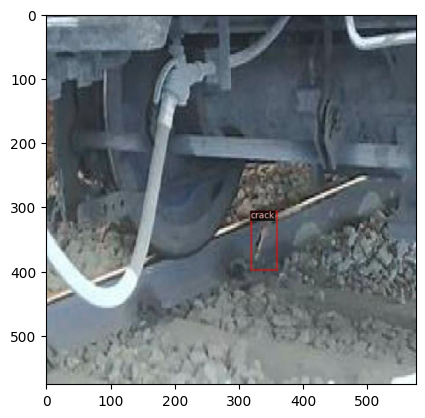

In [7]:
classes = ['cracks-qD5H','crack','large-gap','medium-gap','small gap']
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train").set(thing_classes = classes)
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 6):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.9)
    vis = visualizer.draw_dataset_dict(d)
    # cv2.imshow(vis.get_image()[:, :, ::-1],'mat')
    plt.imshow(vis.get_image()[:, :, ::-1],cmap='gray')

In [11]:
# my_dataset_train_metadata
# dataset_dicts
my_dataset_train_metadata 

namespace(name='my_dataset_train',
          json_file='train/_annotations.coco.json',
          image_root='train',
          evaluator_type='coco',
          thing_classes=['cracks-qD5H',
                         'crack',
                         'large-gap',
                         'medium-gap',
                         'small gap'],
          thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4})

In [16]:
MetadataCatalog.get("my_dataset_test")

namespace(name='my_dataset_test',
          json_file='test/_annotations.coco.json',
          image_root='test',
          evaluator_type='coco')

In [ ]:
# dataset_dicts = DatasetCatalog.get("my_dataset_val")
# dataset_dicts

In [8]:
# !pwd
from detectron2.evaluation import COCOEvaluator
from detectron2.data import DatasetCatalog, MetadataCatalog
import logging

class CustomCOCOEvaluator(COCOEvaluator):
    def _eval_predictions(self, predictions, img_ids=None):
        num_classes = len(self._metadata.thing_classes)
        coco_results = list(
            self.instances_to_coco_json(predictions, self._metadata.thing_classes)
        )
        if len(coco_results) == 0:
            logging.warning("No valid predictions made. Skipping evaluation.")
            return
        reverse_id_mapping = {
            id: k for k, id in self._metadata.thing_dataset_id_to_contiguous_id.items()
        }
        # Filter out invalid predictions
        filtered_results = []
        for result in coco_results:
            category_id = result["category_id"]
            if category_id < num_classes:
                result["category_id"] = reverse_id_mapping[category_id]
                filtered_results.append(result)
            else:
                logging.warning(f"Skipping invalid prediction with class id: {category_id}")

        self._coco_results["bbox"] = filtered_results
        if "segm" in coco_results[0]:
            self._coco_results["segm"] = filtered_results
        return self._coco_results


## Training Using defaultTrainer function 
   * Set the hyperparameters

In [10]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

# class CustomTrainer(DefaultTrainer):
#     @classmethod
#     def build_evaluator(cls, cfg, dataset_name, output_folder=None):
#         if output_folder is None:
#             output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
#         return CustomCOCOEvaluator(dataset_name, cfg, True, output_folder)

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return None  # Disable the evaluator
    def print_class_ids_and_names(self):
        num_classes = self.model.roi_heads.num_classes
        print(f"Number of classes: {num_classes}")
        # Assuming the model's metadata has the classes (this may need adjustments based on actual data structure)
        metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
        class_names = metadata.thing_classes
        for class_id, class_name in enumerate(class_names):
            print(f"Class ID: {class_id}, Class Name: {class_name}")

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.MAX_ITER = 2000  # Adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 # Update to match the number of classes in your dataset

cfg.TEST.EVAL_PERIOD = 0



Loading config /home/anmol/anaconda3/envs/detectron/lib/python3.10/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


* initialize the training

  * it train the model for the number of iterations specified
  * After training save the model in the Output directory
  * and save the metrics in metric.json file

In [19]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[07/05 11:13:35 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


[07/05 11:13:35 d2.engine.train_loop]: Starting training from iteration 0


/home/anmol/anaconda3/envs/detectron/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/anmol/anaconda3/envs/detectron/lib/python3.10/site-packages/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/home/anmol/anaconda3/envs/detectron/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cud

[07/05 11:13:53 d2.utils.events]:  eta: 0:26:47  iter: 19  total_loss: 2.732  loss_cls: 1.802  loss_box_reg: 0.8573    time: 0.8335  last_time: 0.6840  data_time: 0.0137  last_data_time: 0.0057   lr: 3.8962e-05  max_mem: 4299M
[07/05 11:14:08 d2.utils.events]:  eta: 0:25:12  iter: 39  total_loss: 2.083  loss_cls: 1.338  loss_box_reg: 0.7291    time: 0.7887  last_time: 0.7288  data_time: 0.0070  last_data_time: 0.0073   lr: 7.8922e-05  max_mem: 4299M
[07/05 11:14:23 d2.utils.events]:  eta: 0:23:39  iter: 59  total_loss: 1.382  loss_cls: 0.7752  loss_box_reg: 0.6274    time: 0.7751  last_time: 0.7287  data_time: 0.0062  last_data_time: 0.0059   lr: 0.00011888  max_mem: 4299M
[07/05 11:14:38 d2.utils.events]:  eta: 0:23:28  iter: 79  total_loss: 1.291  loss_cls: 0.7172  loss_box_reg: 0.5727    time: 0.7740  last_time: 0.8155  data_time: 0.0066  last_data_time: 0.0072   lr: 0.00015884  max_mem: 4299M
[07/05 11:14:54 d2.utils.events]:  eta: 0:23:14  iter: 99  total_loss: 1.136  loss_cls: 0.

### Testing
   * load the model from output folder

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 1
  # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
predictor = DefaultPredictor(cfg)        # function for predicting image
test_metadata = MetadataCatalog.get("my_dataset_test")

[07/09 16:26:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


* visualize the prediction

(640, 640, 3)
<class 'dict'>
Instances(num_instances=75, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[263.9951, 107.6905, 390.3917, 261.0635],
        [345.7154, 376.0581, 433.1076, 455.9865],
        [345.7154, 376.0581, 433.1076, 455.9865],
        [114.2160, 276.3194, 214.7526, 405.6975],
        [274.6237, 115.0273, 347.7573, 244.9855],
        [ 45.9231, 259.4563, 223.2248, 412.1196],
        [320.2607, 363.8871, 453.2156, 474.7765],
        [227.6538,  81.8644, 418.2265, 293.5979],
        [261.5015, 102.7862, 387.4388, 264.4102],
        [345.7154, 376.0581, 433.1076, 455.9865],
        [250.2631,  97.1404, 405.7890, 280.8486],
        [320.2607, 363.8871, 453.2156, 474.7765],
        [116.0413,  85.2291, 408.5000, 404.8528],
        [101.7124, 251.2269, 276.0608, 435.4647],
        [131.1612, 284.9662, 192.1507, 389.8573],
        [361.8700, 388.4186, 414.8742, 442.3340],
        [281.6658, 108.9672, 336.4985, 200.6902],
        [333.3414, 393.5618, 434

(576, 576, 3)

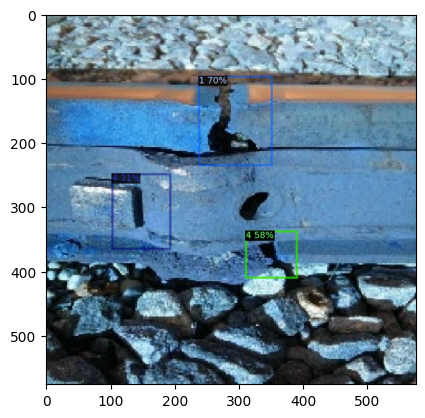

In [14]:
from detectron2.utils.visualizer import ColorMode
from torchvision.ops import nms                                                            # there is some error showing by this cell for some of the file

# for imageName in glob.glob('test/*jpg'):
imageName = 'train/2007-05-16_-_002_Broken_rail_weld_-_Flickr_-_faxepl-1-_jpg.rf.73c714a4da20729cb68a048b6206af0f.jpg'
im = cv2.imread(imageName)
score_threshold = 0.3
print(np.shape(im))
outputs = predictor(im)
print(type(outputs))

print(outputs['instances'])
type(outputs['instances'])

instances = outputs['instances']
high_score_indices = instances.scores > score_threshold
instances = instances[high_score_indices]
# Apply Non-Maximum Suppression (NMS)
boxes = instances.pred_boxes.tensor
scores = instances.scores
print(scores)
keep = nms(boxes, scores, iou_threshold=1)
filtered_instances = instances[keep]
string = str(outputs['instances'])
v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.9
                 )
out = v.draw_instance_predictions(filtered_instances.to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])
plt.imshow(out.get_image()[:, :, ::-1],cmap='gray')
np.shape(out.get_image()[:, :, ::-1])

##### resolving it :: 
  * convert the output into a string
  * take the bounding box correspond to the max tensor score

In [29]:
string

"Instances(num_instances=87, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[1.9619e+02, 9.6081e+01, 3.9520e+02, 3.3786e+02],\n        [1.9952e+02, 9.2175e+01, 3.9025e+02, 3.3829e+02],\n        [1.3877e+02, 2.9017e+00, 4.2899e+02, 3.1698e+02],\n        [1.9231e+02, 8.9875e+01, 4.0091e+02, 3.4431e+02],\n        [2.5983e+02, 1.6307e+02, 3.9197e+02, 3.6562e+02],\n        [1.4892e+02, 1.5084e+02, 4.7521e+02, 5.2838e+02],\n        [8.3773e+01, 6.0011e+01, 3.9534e+02, 4.2207e+02],\n        [1.0714e+02, 6.3351e+01, 3.0233e+02, 2.5872e+02],\n        [8.5896e+01, 7.5675e+01, 2.4934e+02, 2.1380e+02],\n        [2.6109e+02, 2.1733e+02, 4.4962e+02, 5.3351e+02],\n        [1.3515e+02, 8.6452e+01, 2.4249e+02, 1.9143e+02],\n        [3.4381e+02, 2.6674e+02, 5.2112e+02, 4.3037e+02],\n        [1.7738e+02, 2.9223e+01, 3.5917e+02, 2.6652e+02],\n        [9.5987e+01, 8.8907e+01, 2.0947e+02, 1.8587e+02],\n        [2.2183e+02, 9.1477e+01, 3.4382e+02, 2.7719e+02],\n        [2.9867e+02, 2.04

##### function for finding max score, and maxscore index

In [15]:
def findmaxscore(string):
    list1 = string.split('scores: tensor([')
    right_part = list1[1]
    tensstr = right_part.split("], device='cuda:0'")
    print(tensstr[0])
    if tensstr[0] == '':
      print("No Bounding boxes ")
      maxscore = -1
      maxscoreinx = -1
      return maxscoreinx,maxscore,
    elif'\n        ' in tensstr[0]:
       lp = tensstr[0].split(",\n        ")[0].split(', ')
       rp = tensstr[0].split(",\n        ")[1].split(', ')
       for i in rp:
         lp.append(i)
    else :
       lp = tensstr[0].split(", ")
    listm = []
    for i in lp:
      listm.append(float(i))
    print(listm)
    maxscore = max(listm)
    maxscoreindx =listm.index( max(listm))
    print(max(listm))
    return maxscoreindx,maxscore

##### function for finding the bounding box

In [16]:
def getbbox(string,scoreinx):
    if scoreinx == -1 :
        bbox = [0,0,0,0]
        return bbox
    list1 = string.split('Boxes(tensor([')
    right_part = list1[1]
    tensstr = right_part.split("], device='cuda:0'))")[0].split("\n        ")
    tensstr = tensstr[scoreinx].split(", ")
    x_min = float(tensstr[0][1::])
    y_min = float(tensstr[1])
    width = float(tensstr[2])
    height = float(tensstr[-1][:-2:])
    bbox = [x_min,y_min,width,height]
    return bbox



In [17]:
scoreinx,maxscore = findmaxscore(string)
scoreinx
maxscore

0.6966, 0.6842, 0.5801, 0.3068, 0.2733, 0.2229, 0.2172, 0.2143, 0.2065,
        0.1797, 0.1771, 0.1278, 0.1264, 0.1164, 0.1038, 0.1029, 0.1005, 0.0992,
        0.0964, 0.0959, 0.0952, 0.0948, 0.0929, 0.0859, 0.0836, 0.0836, 0.0825,
        0.0808, 0.0795, 0.0785, 0.0774, 0.0758, 0.0756, 0.0731, 0.0723, 0.0721,
        0.0702, 0.0693, 0.0685, 0.0670, 0.0665, 0.0652, 0.0646, 0.0643, 0.0637,
        0.0634, 0.0634, 0.0629, 0.0628, 0.0616, 0.0607, 0.0605, 0.0603, 0.0594,
        0.0588, 0.0587, 0.0580, 0.0579, 0.0558, 0.0556, 0.0552, 0.0548, 0.0545,
        0.0545, 0.0537, 0.0536, 0.0532, 0.0528, 0.0524, 0.0520, 0.0519, 0.0514,
        0.0508, 0.0506, 0.0501
[0.6966, 0.6842, 0.5801, 0.3068, 0.2733, 0.2229, 0.2172, 0.2143, 0.2065, 0.1797, 0.1771, 0.1278, 0.1264, 0.1164, 0.1038, 0.1029, 0.1005, 0.0992]
0.6966


0.6966

In [18]:
bbox = getbbox(string,scoreinx)
bbox

[263.9951, 107.6905, 390.3917, 261.0635]

In [19]:
l = np.shape(out.get_image()[:, :, ::-1])
type(l)
l[1::-1]

(576, 576)

In [20]:
def predandshow(imageName):
    
    # imageName = '/home/anmol/internship/datasets/custom generator/test/GH042660-MP4_001141-236_jpg.rf.f57fb98699ec715f033247df5ffc154e.jpg'
    image = cv2.imread(imageName)
    image = cv2.resize(image,l[1::-1])

    x_min, y_min, x_max, y_max = bbox
    # x_max = x_min + width
    # y_max = y_min + height
    
    # Draw the rectangle on the image
    cv2.rectangle(image, (int(x_min-((10*l[1::-1][1])/100)), int(y_min-((5*l[1::-1][0])/100))), (int(x_max), int(y_max)), (0, 255, 0), thickness=3)

    text = f'Score: {maxscore}'
    
    # Choose font
    font = cv2.FONT_HERSHEY_DUPLEX
    
    
    # Get the text size
    (text_width, text_height), baseline = cv2.getTextSize(text, font, 0.6, 1)
    
    # Calculate the position for the text
    text_x = int(int(x_min-((10*l[1::-1][1])/100)))

    # text_x = int(x_min-25)
    text_y = int(y_min-((5*l[1::-1][0])/100)) - 10

    # text_y = int(y_min-25) - 10
    
    # Make sure the text is above the rectangle and not outside the image
    if text_y < 0:
        text_y = int(y_min-25) + text_height + 10
    
    # Draw the text on the image
    cv2.putText(image, text, (text_x, text_y), font, 
                1, (255, 0, 0), 3)
    # Display the image
    # cv2.imshow('Image with Bounding Box', image)
    plt.imshow(image,cmap='gray')
    plt.show()

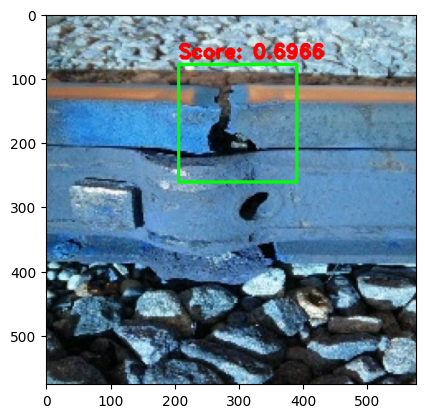

In [21]:
predandshow(imageName)

In [1]:
!pwd

/home/anmol/internship/Detectron


#### Validation

In [19]:
import detectron2
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Load the configuration file
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.MODEL.WEIGHTS = "output/model_final.pth"  # Path to the trained model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val")

# Create the predictor
predictor = DefaultPredictor(cfg)

# Set up the COCO evaluator
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./outputp/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")

# Perform inference on the dataset and evaluate
results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Print evaluation results
print(results)


Loading config /home/anmol/anaconda3/envs/detectron/lib/python3.10/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[07/05 16:23:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/model_final.pth ...
WARNING [07/05 16:23:56 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [07/05 16:23:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/05 16:23:56 d2.data.datasets.coco]: Loaded 655 images in COCO format from valid/_annotations.coco.json
[07/05 16:23:56 d2.data.build]: Distribution of instances among all 5 categories:
|  category   | #instances   |  category  | #instances   |  category  | #instances   |
|:-----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| cracks-qD5H | 0            |   crack    | 102          | large-gap  | 0            |
| medium-gap  | 6            | small gap  | 430          |            |              |
|    total    | 538          |        